In [1]:
# import all required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA, TruncatedSVD
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder

In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.7 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read the dataset 
df = pd.read_csv("/Users/hkannan/Desktop/COMP90089_MLAH/Dataset_final/AP_ICD_Lipase/AP_ICD_Lipase_Comorbidities_Dataset.csv")

In [4]:
df

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,age,race,in_hospital_death,length_of_stay,icd_code_AP,icd_code,seq_num,icd_version,long_title
0,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556,K8510,G40409,1,10,Other generalized epilepsy and epileptic syndr...
1,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556,K8510,K8510,2,10,Biliary acute pancreatitis without necrosis or...
2,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556,K8510,G9340,3,10,"Encephalopathy, unspecified"
3,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556,K8510,K8064,4,10,Calculus of gallbladder and bile duct with chr...
4,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556,K8510,E871,5,10,Hypo-osmolality and hyponatremia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18998,19996968,29843339,2125-01-23 06:25:00,508.0,2125-01-20 21:17:00,2125-01-23 14:42:00,M,32,BLACK/AFRICAN AMERICAN,False,2.725694,5770,5770,1,9,Acute pancreatitis
18999,19996968,29843339,2125-01-23 06:25:00,508.0,2125-01-20 21:17:00,2125-01-23 14:42:00,M,32,BLACK/AFRICAN AMERICAN,False,2.725694,5770,30391,2,9,"Other and unspecified alcohol dependence, cont..."
19000,19996968,29843339,2125-01-23 06:25:00,508.0,2125-01-20 21:17:00,2125-01-23 14:42:00,M,32,BLACK/AFRICAN AMERICAN,False,2.725694,5770,4019,3,9,Unspecified essential hypertension
19001,19996968,29843339,2125-01-23 06:25:00,508.0,2125-01-20 21:17:00,2125-01-23 14:42:00,M,32,BLACK/AFRICAN AMERICAN,False,2.725694,5770,V1581,4,9,Personal history of noncompliance with medical...


In [5]:
# concatenate all unique diseases as features
disease_dummies = pd.get_dummies(df['long_title'])
data = pd.concat([df, disease_dummies], axis = 1).drop('long_title', axis = 1)

In [6]:
# aggregate all the rows into unique patients based on subject_id
aggregated_data = data.groupby('subject_id').agg({
    'lipase_level': 'first', 
    'age': 'first',
    'gender': 'first',
    'race': 'first',
    'in_hospital_death': 'max',  # If death recorded in any row, we consider the patient deceased
    'length_of_stay': 'first', 
    **{col: 'max' for col in disease_dummies.columns}  # max for binary disease presence across multiple rows
}).reset_index()

In [7]:
aggregated_data

,subject_id,lipase_level,age,gender,race,in_hospital_death,length_of_stay,16 weeks gestation of pregnancy,34 weeks gestation of pregnancy,Abdominal aneurysm without mention of rupture,...,"Vitreous hemorrhage, left eye","Volume depletion, unspecified",Vomiting alone,Von Willebrand's disease,Weakness,Wegener's granulomatosis,Wernicke's encephalopathy,Wheelchair dependence,Wheezing,Zoster without complications
0,10004606,1222.0,64,F,WHITE,False,14.130556,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,10006431,508.0,66,F,WHITE,False,6.654167,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,10017531,1164.0,63,M,WHITE,False,31.756944,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10021357,1249.0,91,F,WHITE,False,8.009028,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,10036086,677.0,57,M,WHITE,False,23.371528,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,19951256,3241.0,56,F,HISPANIC/LATINO - COLUMBIAN,False,1.729861,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1362,19970491,487.0,55,M,WHITE,False,6.826389,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1363,19977727,528.0,64,F,WHITE,False,1.654861,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1364,19990545,1886.0,43,F,ASIAN - ASIAN INDIAN,False,24.690278,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# grouping all variants of AP into single column
columns_to_drop = [col for col in aggregated_data.columns if 'acute pancreatitis' in col.lower()]
columns_to_drop,len(columns_to_drop)

(['Acute pancreatitis',
  'Acute pancreatitis with infected necrosis, unspecified',
  'Acute pancreatitis with uninfected necrosis, unspecified',
  'Acute pancreatitis without necrosis or infection, unspecified',
  'Acute pancreatitis, unspecified',
  'Alcohol induced acute pancreatitis',
  'Alcohol induced acute pancreatitis with infected necrosis',
  'Alcohol induced acute pancreatitis with uninfected necrosis',
  'Alcohol induced acute pancreatitis without necrosis or infection',
  'Biliary acute pancreatitis',
  'Biliary acute pancreatitis with infected necrosis',
  'Biliary acute pancreatitis with uninfected necrosis',
  'Biliary acute pancreatitis without necrosis or infection',
  'Drug induced acute pancreatitis',
  'Drug induced acute pancreatitis with uninfected necrosis',
  'Drug induced acute pancreatitis without necrosis or infection',
  'Idiopathic acute pancreatitis',
  'Idiopathic acute pancreatitis without necrosis or infection',
  'Other acute pancreatitis',
  'Other a

In [8]:
aggregated_data.drop(columns = columns_to_drop, inplace = True)
aggregated_data['Acute pancreatitis'] = True
aggregated_data

,subject_id,lipase_level,age,gender,race,in_hospital_death,length_of_stay,16 weeks gestation of pregnancy,34 weeks gestation of pregnancy,Abdominal aneurysm without mention of rupture,...,"Volume depletion, unspecified",Vomiting alone,Von Willebrand's disease,Weakness,Wegener's granulomatosis,Wernicke's encephalopathy,Wheelchair dependence,Wheezing,Zoster without complications,Acute pancreatitis
0,10004606,1222.0,64,F,WHITE,False,14.130556,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,10006431,508.0,66,F,WHITE,False,6.654167,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,10017531,1164.0,63,M,WHITE,False,31.756944,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,10021357,1249.0,91,F,WHITE,False,8.009028,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,10036086,677.0,57,M,WHITE,False,23.371528,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,19951256,3241.0,56,F,HISPANIC/LATINO - COLUMBIAN,False,1.729861,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1362,19970491,487.0,55,M,WHITE,False,6.826389,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1363,19977727,528.0,64,F,WHITE,False,1.654861,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1364,19990545,1886.0,43,F,ASIAN - ASIAN INDIAN,False,24.690278,False,False,False,...,False,False,False,False,False,False,False,False,False,True


<H1>EDA</H1>

In [11]:
# check if null values are present in the dataset
aggregated_data.isna().sum()

subject_id                      0
lipase_level                    0
age                             0
gender                          0
race                            0
                               ..
Wernicke's encephalopathy       0
Wheelchair dependence           0
Wheezing                        0
Zoster without complications    0
Acute pancreatitis              0
Length: 2683, dtype: int64

### Dataset Overview 

In [78]:
Total_patients = 180677
AP_count = [3849, 1366, 156]
AP_death = [141, 69, 31]

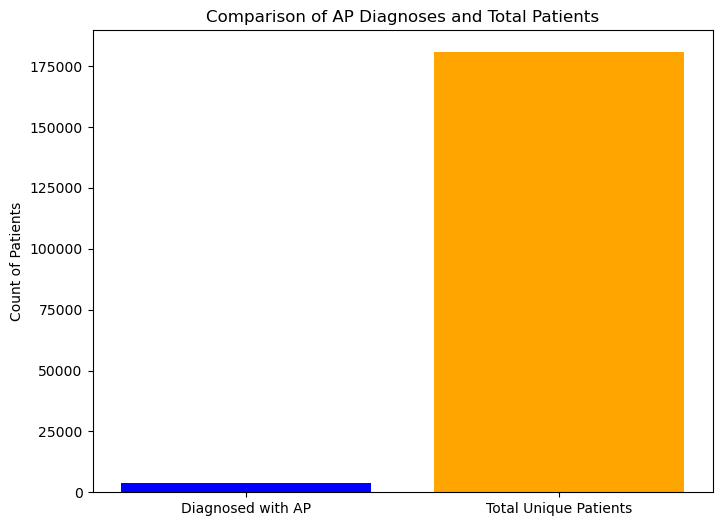

In [92]:
count_diagnosed_with_AP = AP_count[0]
total_unique_patients = Total_patients

# Labels and counts
labels = ['Diagnosed with AP', 'Total Unique Patients']
counts = [count_diagnosed_with_AP, total_unique_patients]

# Create bar chart
plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(labels, counts, color = ['blue', 'orange'])  # Plot bars with different colors

# Adding titles and labels
plt.title('Comparison of AP Diagnoses and Total Patients')
plt.ylabel('Count of Patients')

# Show plot
plt.show()

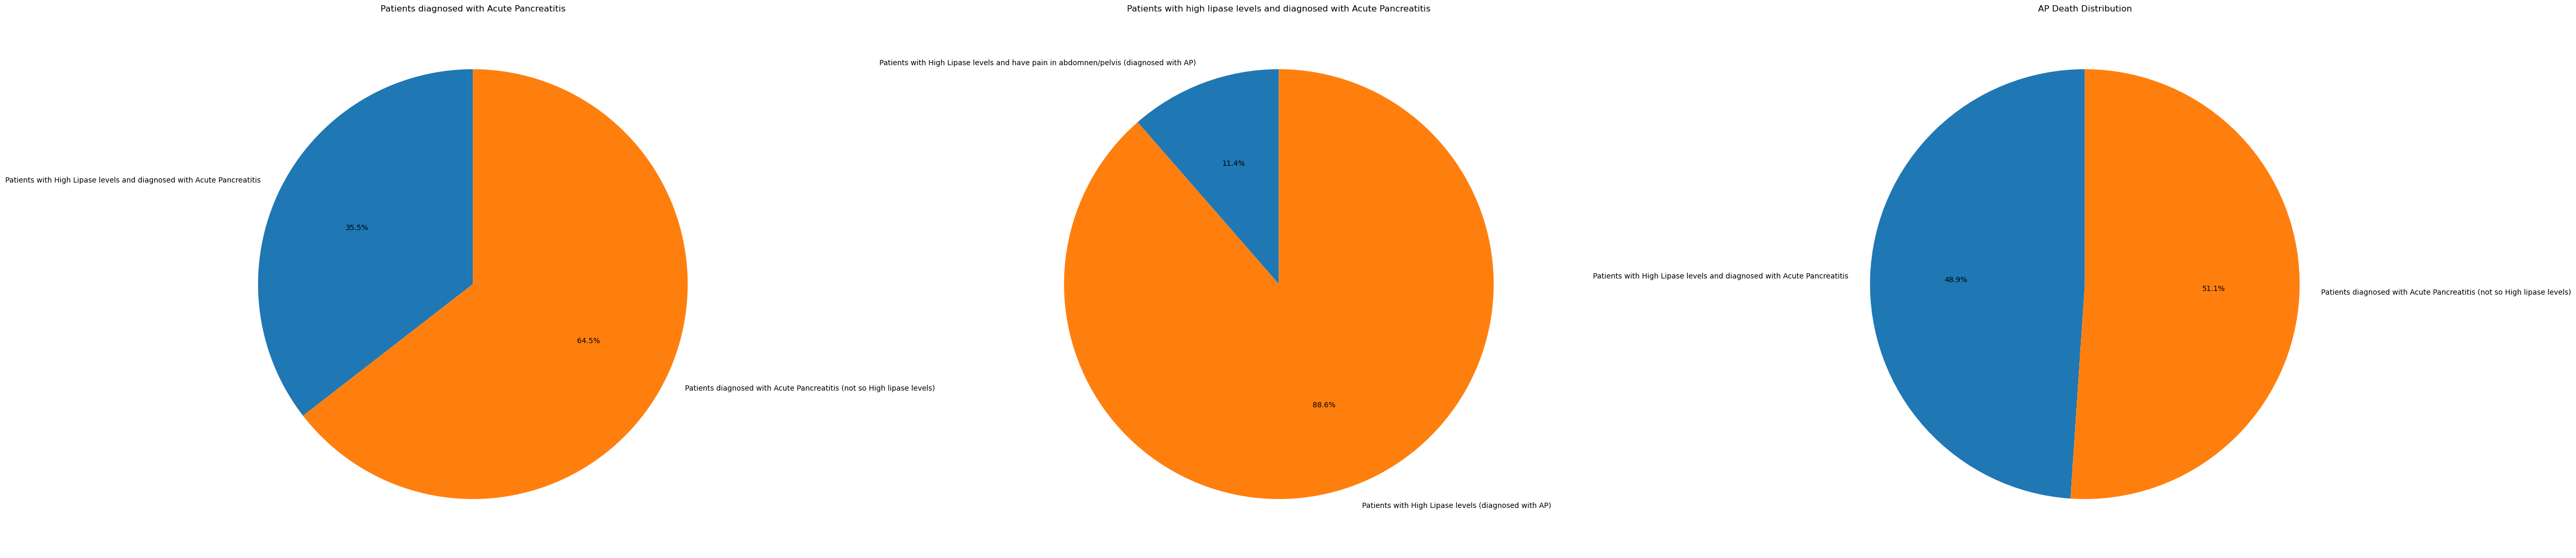

In [89]:
# Labels for the slices
labels_group1 = ['Patients with High Lipase levels and diagnosed with Acute Pancreatitis', 'Patients diagnosed with Acute Pancreatitis (not so High lipase levels)']
labels_group2 = ['Patients with High Lipase levels and have pain in abdomnen/pelvis (diagnosed with AP)', 'Patients with High Lipase levels (diagnosed with AP)']

# Create a figure with three subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize = (48, 12))  # 18x6 figure size

# Adjust the data to reflect nested groups
counts_group1_exclusive = [AP_count[1], AP_count[0] - AP_count[1]]
counts_group2_exclusive = [AP_count[2], AP_count[1] - AP_count[2]]
deaths_group1_exclusive = [AP_death[1], AP_death[0] - AP_death[1]]

# Plotting the pie charts
axs[0].pie(counts_group1_exclusive, labels = labels_group1, autopct = '%1.1f%%', startangle = 90)
axs[0].set_title('Patients diagnosed with Acute Pancreatitis')

axs[1].pie(counts_group2_exclusive, labels = labels_group2, autopct = '%1.1f%%', startangle = 90)
axs[1].set_title('Patients with high lipase levels and diagnosed with Acute Pancreatitis')

axs[2].pie(deaths_group1_exclusive, labels = labels_group1, autopct = '%1.1f%%', startangle = 90)
axs[2].set_title('AP Death Distribution')

# Show the plot
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

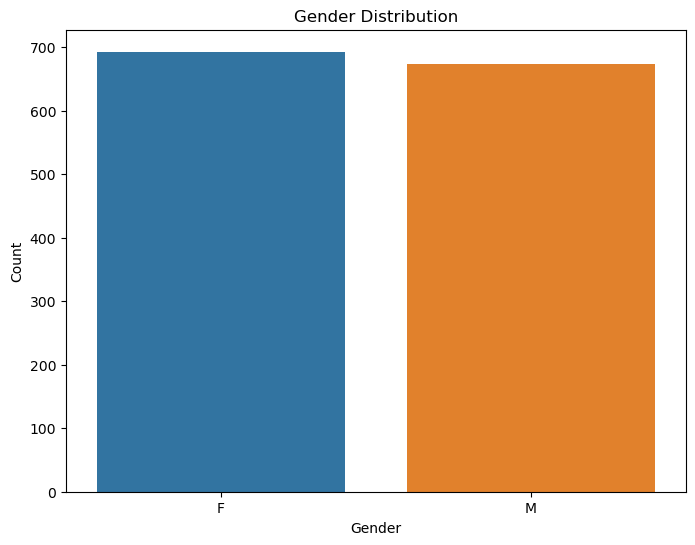

In [12]:
# visualize the distribution of data (features)
# Gender
plt.figure(figsize = (8, 6))
sns.countplot(x = 'gender', data = aggregated_data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

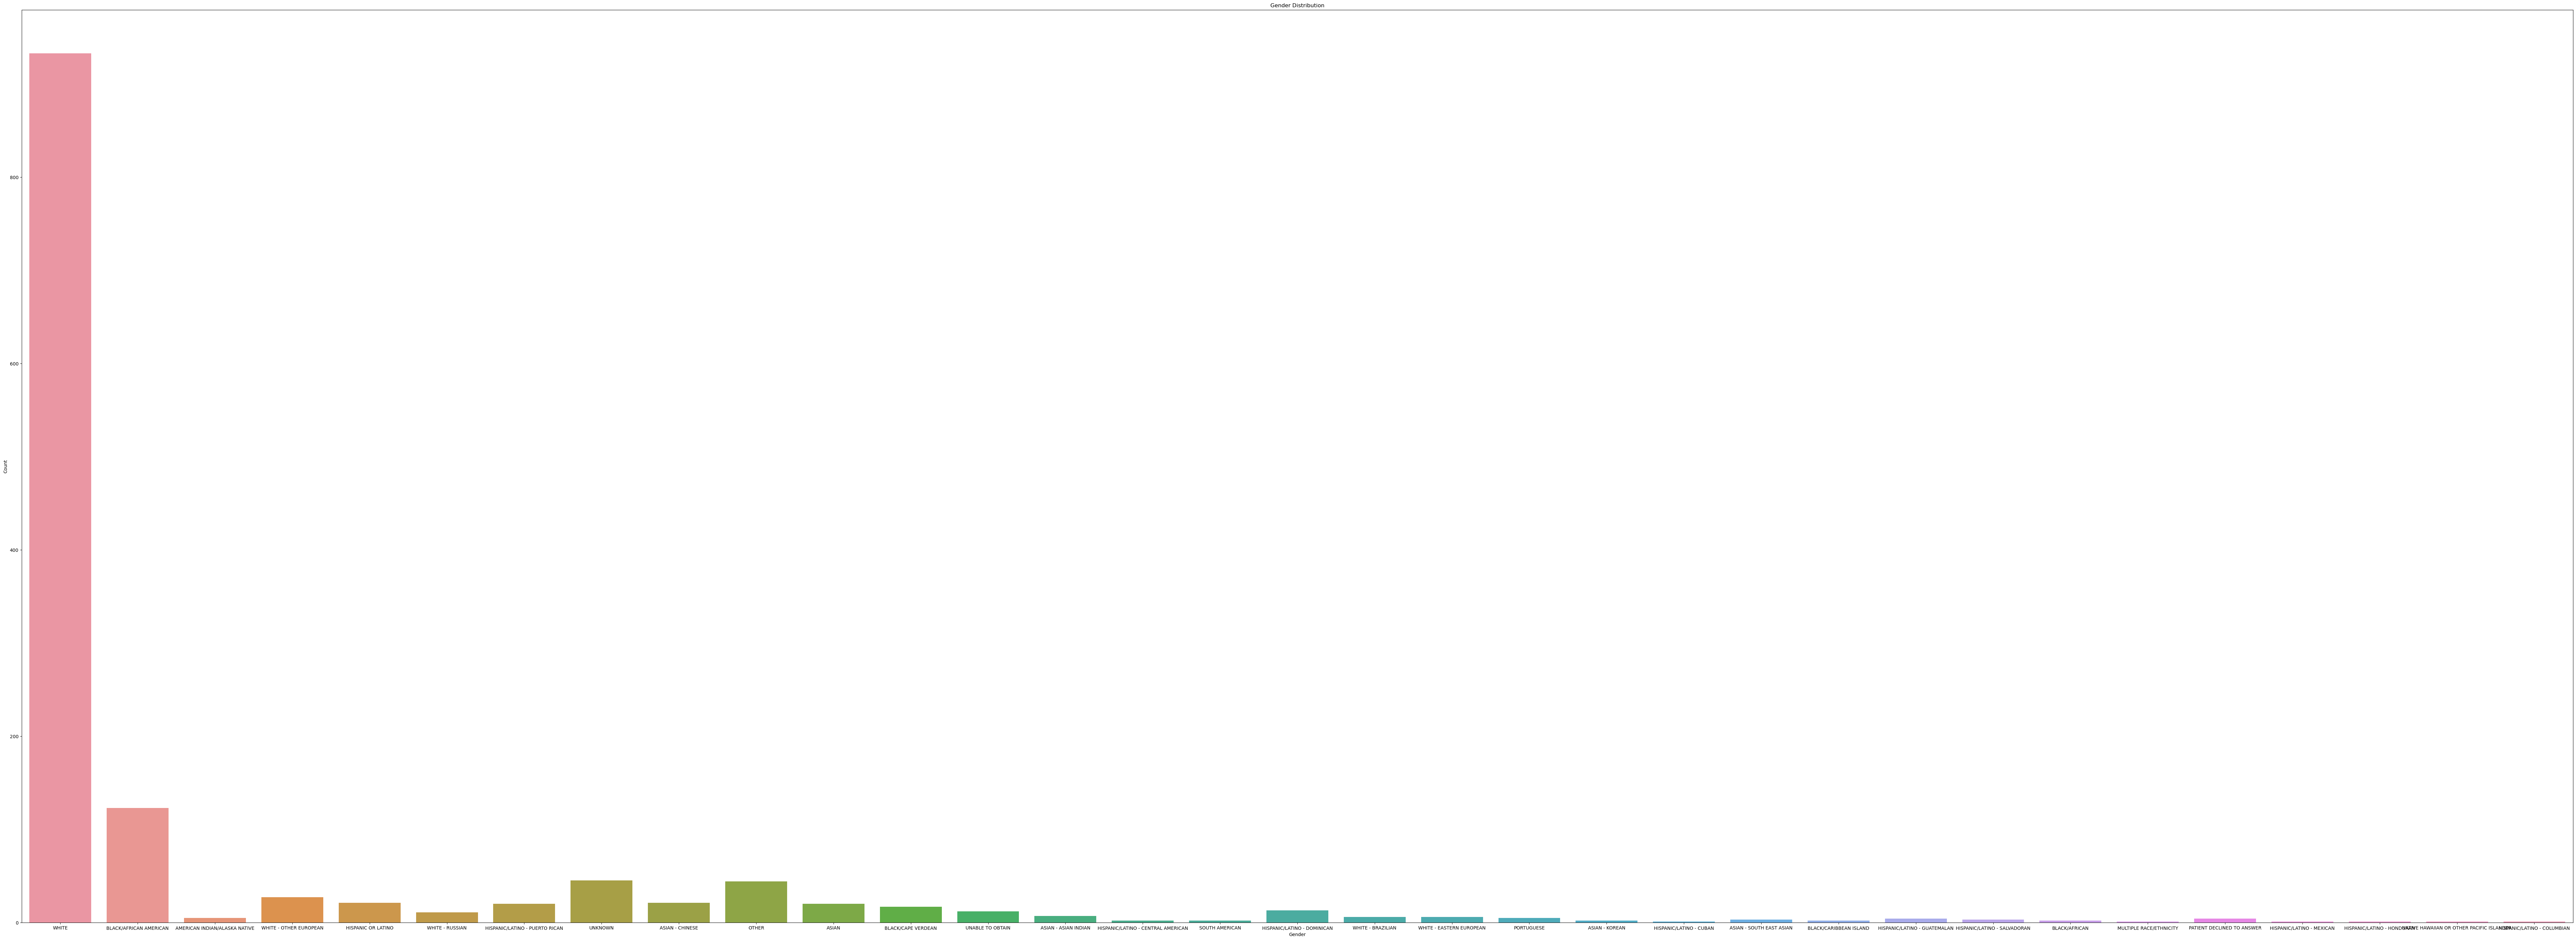

In [22]:
# Race
plt.figure(figsize = (100, 36))
sns.countplot(x = 'race', data = aggregated_data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

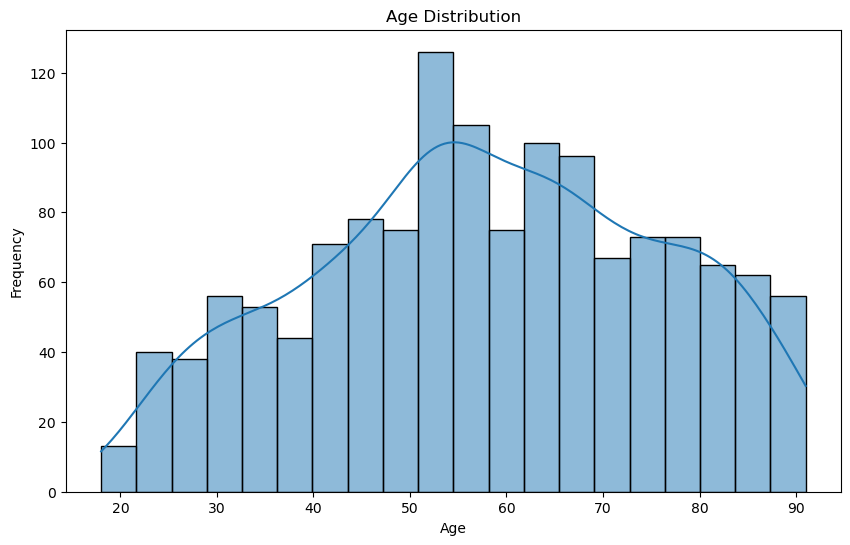

In [23]:
# Age
plt.figure(figsize = (10, 6))
sns.histplot(aggregated_data['age'], bins = 20, kde = True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

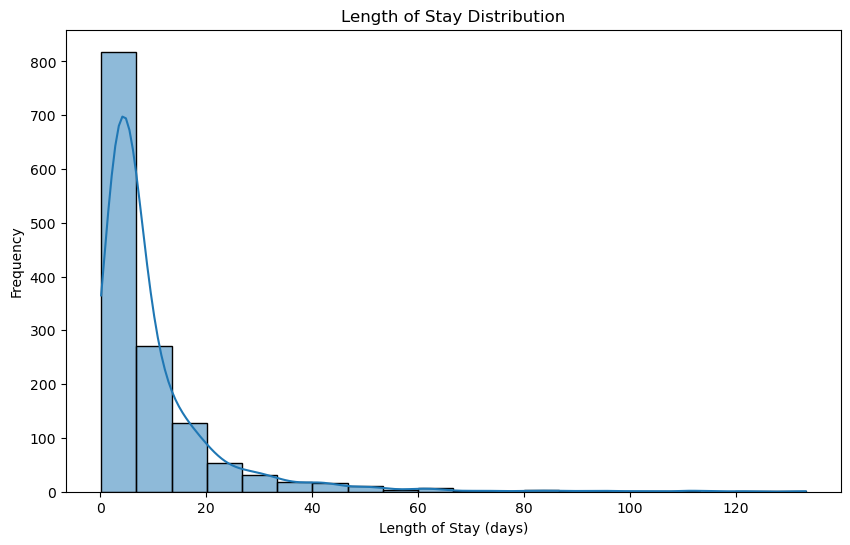

In [24]:
# Length of stay
plt.figure(figsize = (10, 6))
sns.histplot(aggregated_data['length_of_stay'], bins = 20, kde = True)
plt.title('Length of Stay Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

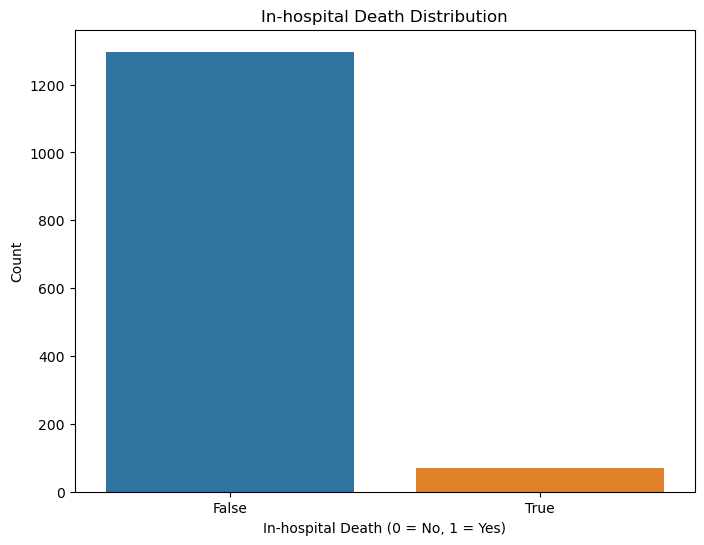

In [25]:
# In-hospital death
plt.figure(figsize = (8, 6))
sns.countplot(x = 'in_hospital_death', data = aggregated_data)
plt.title('In-hospital Death Distribution')
plt.xlabel('In-hospital Death (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

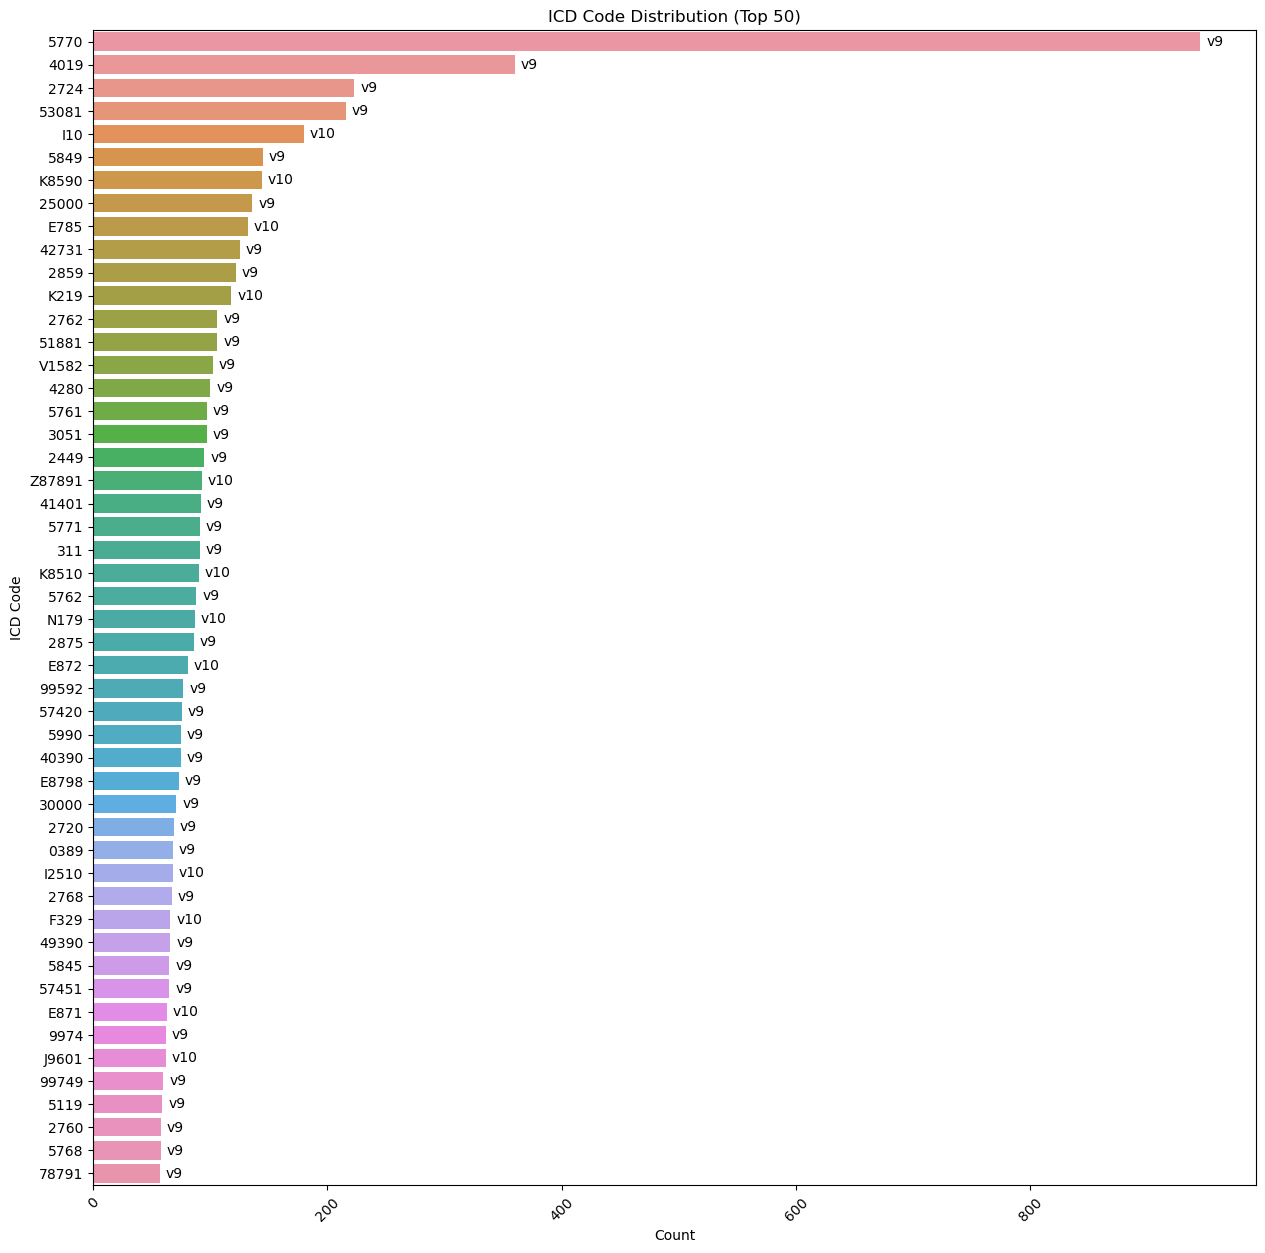

In [26]:
# ICD codes distribution
plt.figure(figsize = (15, 15))
ax = sns.countplot(y = 'icd_code',
                   data = df,
                   order = df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')
for index, patch in enumerate(ax.patches):
    icd_code = df['icd_code'].value_counts().index[:50][index]
    icd_version = df.loc[df['icd_code'] == icd_code, 'icd_version'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'v{icd_version}', va='center')
plt.xticks(rotation=45)
plt.show()

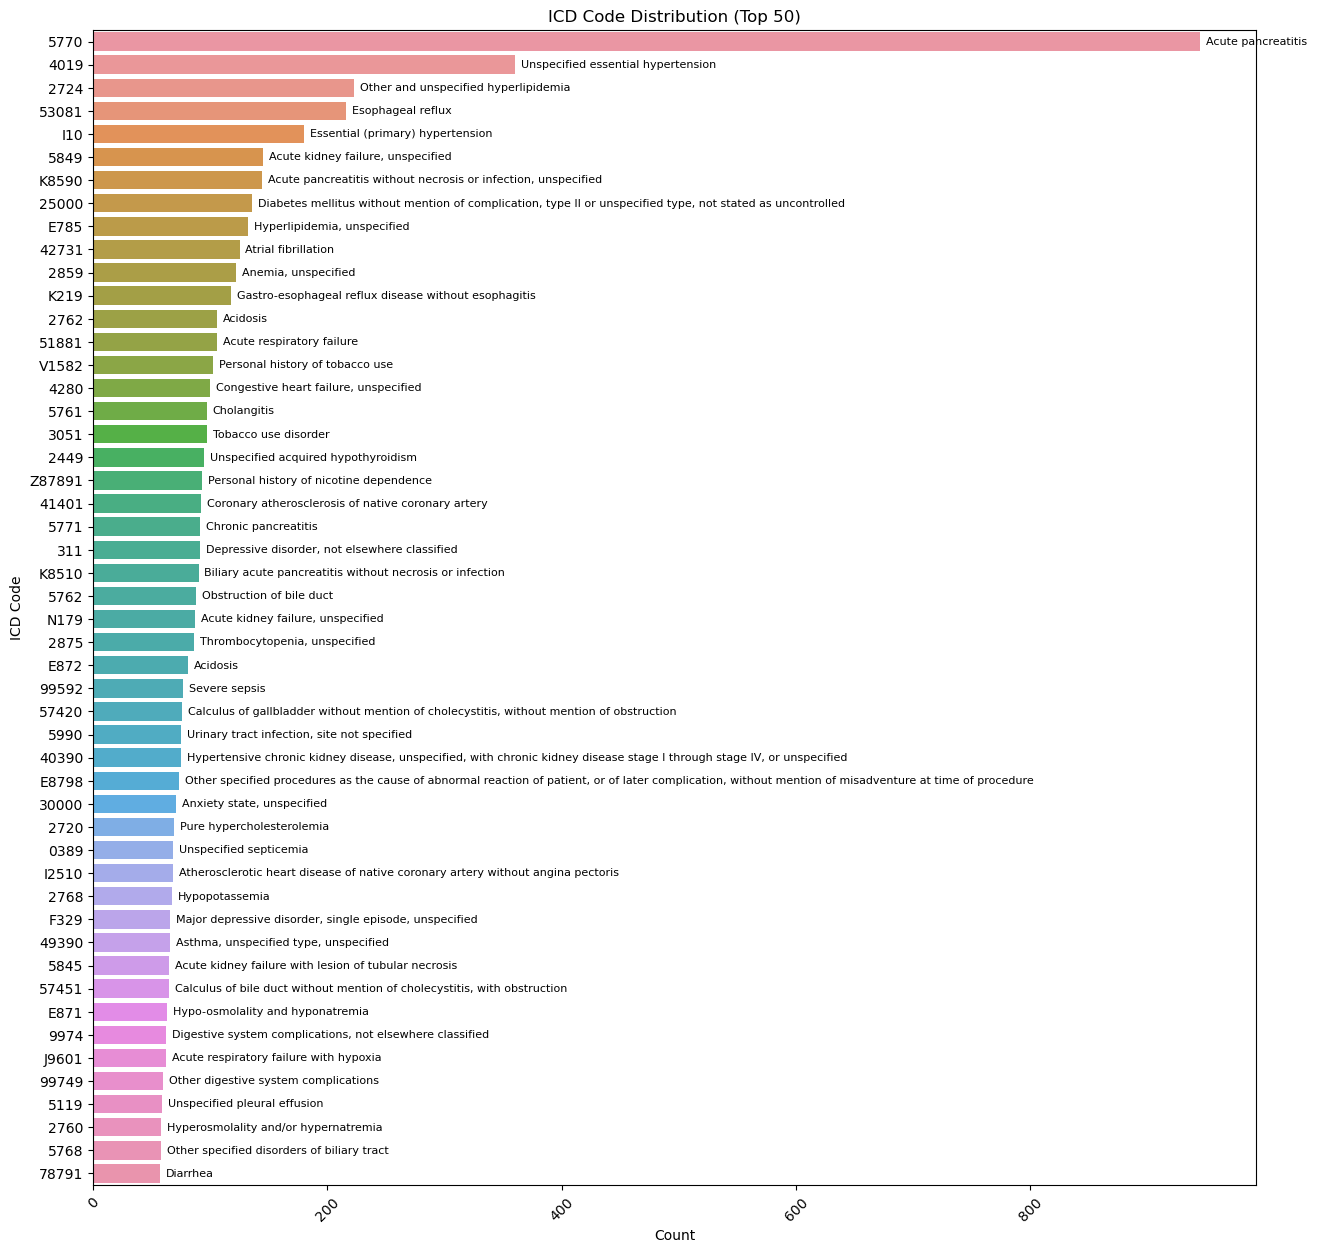

In [27]:
# ICD codes distribution
plt.figure(figsize = (15, 15))
ax = sns.countplot(y = 'icd_code',
                   data = df,
                   order = df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')

for index, patch in enumerate(ax.patches):
    icd_code = df['icd_code'].value_counts().index[:50][index]
    long_title = df.loc[df['icd_code'] == icd_code, 'long_title'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'{long_title}', va='center', fontsize=8, color='black')

plt.xticks(rotation=45)
plt.show()

<H1>Feature Selection</H1>

In [11]:
X = aggregated_data.drop(['subject_id', 'in_hospital_death'], axis = 1)
y = aggregated_data['in_hospital_death'].astype(int)  # Converting boolean to int

X_encoded = X.apply(LabelEncoder().fit_transform)

# Apply Chi-squared test
chi2_features = SelectKBest(score_func = chi2, k = 'all')  # 'all' to test each feature
chi2_features.fit(X_encoded, y)
chi2_scores = pd.DataFrame(chi2_features.scores_, columns = ['score'], index = X.columns)
chi2_p_values = pd.DataFrame(chi2_features.pvalues_, columns = ['p-value'], index = X.columns)
chi2_results = pd.concat([chi2_scores, chi2_p_values], axis=1)

print(chi2_results.sort_values(by = 'score', ascending = False))  

                                                           score       p-value
length_of_stay                                      2.349693e+03  0.000000e+00
Encounter for palliative care                       3.252519e+02  1.039784e-72
Severe sepsis                                       1.323794e+02  1.235918e-30
Acute kidney failure with lesion of tubular nec...  1.247002e+02  5.919617e-29
Acute respiratory failure                           1.194780e+02  8.230125e-28
...                                                          ...           ...
Mitral valve disorders                              1.779028e-03  9.663564e-01
Other postoperative infection                       1.095058e-04  9.916507e-01
Encephalopathy, unspecified                         1.095058e-04  9.916507e-01
gender                                              8.135644e-07  9.992803e-01
Acute pancreatitis                                           NaN           NaN

[2681 rows x 2 columns]


In [12]:
significant_features = chi2_results[chi2_results['p-value'] < 0.05]
significant_features.index, len(significant_features)

(Index(['lipase_level', 'age', 'length_of_stay',
        'Abdominal aneurysm without mention of rupture',
        'Abnormal involuntary movements',
        'Abnormal uterine and vaginal bleeding, unspecified',
        'Accidental cut, puncture, perforation or hemorrhage during other specified medical care',
        'Accidental puncture and laceration of a digestive system organ or structure during a digestive system procedure',
        'Accidental puncture or laceration during a procedure, not elsewhere classified',
        'Acidosis',
        ...
        'Unspecified protein-calorie malnutrition', 'Unspecified septicemia',
        'Unspecified systolic (congestive) heart failure',
        'Unspecified viral hepatitis C with hepatic coma',
        'Varicose veins of left lower extremity with both ulcer of other part of lower extremity and inflammation',
        'Varicose veins of right lower extremity with both ulcer of other part of lower extremity and inflammation',
        'Vascular

<H1>Modelling</H1>

In [13]:
# defining features and labels to fit the models
X = aggregated_data.drop(['subject_id', 'in_hospital_death'], axis = 1)
y = aggregated_data['in_hospital_death'].astype(int)  # Converting boolean to int

# Encoding categorical variables and scaling numerical features
categorical_features = ['gender', 'race']

additional_column = ['Acute pancreatitis']
X = X[categorical_features + list(significant_features.index) + additional_column] 

last_initial_numeric_index = X.columns.tolist().index('length_of_stay')

disease_features = X.columns[last_initial_numeric_index + 1:].tolist()

# Complete list of numeric features now includes the disease vector columns
numeric_features = ['lipase_level', 'age', 'length_of_stay']

binary_features = disease_features  # Assuming these are correctly identified in your code

#svd_transformer = Pipeline(steps=[
#    ('svd', TruncatedSVD(n_components = 100, random_state = 42)) # select only top 100 components for the binary features (diseases)
#])

preprocessor = ColumnTransformer(
    transformers = [ 
        ('num', StandardScaler(), numeric_features),
        #('binary', svd_transformer, binary_features),  # No need to scale binary features
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [32]:
# Using Grid Search to perform hyperparameter tuning by 10-fold cross-validation and optimizing for the 'average_precision' scoring metric
models = {
    'Logistic Regression': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', LogisticRegression())]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__solver': ['liblinear']
        }
    },
    
    'Random Forest': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', RandomForestClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    
    'Gradient Boosting': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', GradientBoostingClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    
    'SVM': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', SVC(probability=True))]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    
    'Decision Tree': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', DecisionTreeClassifier())]),
        'params': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    
    'K-Nearest Neighbors': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', KNeighborsClassifier())]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    
    'AdaBoost': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', AdaBoostClassifier())]),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.5]
        }
    },
    
    'XGBoost': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'))]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.7, 0.9, 1]
        }
}

}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Loop through each model and perform grid search
for name, model in models.items():
    grid_search = GridSearchCV(estimator = model['pipeline'], param_grid = model['params'], cv = 10, scoring = 'average_precision')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Logistic Regression: {'classifier__C': 1.0, 'classifier__solver': 'liblinear'}
Best parameters for Random Forest: {'classifier__max_depth': 7, 'classifier__n_estimators': 100}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best parameters for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 10}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best parameters for AdaBoost: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.7}


In [33]:
# fit all the models with the best parameters and evaluate each of their performance
models = {
    'Logistic Regression': LogisticRegression(C = 1, solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(max_depth = 7, n_estimators = 100),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 200),
    'SVM': SVC(C = 10, kernel = 'rbf',  probability = True),
    'KNN': KNeighborsClassifier(n_neighbors = 7, weights = 'distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth = 3, min_samples_split = 10, class_weight = 'balanced'),
    'AdaBoost': AdaBoostClassifier(learning_rate = 0.1, n_estimators = 100),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', learning_rate = 0.1, max_depth = 5, n_estimators = 100, subsample = 0.7)
}

# Dictionary to store performance
performance = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Evaluate each model
for name, model in models.items():
    # Create and fit the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store performance
    performance[name] = {
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'F1 Score': f1, 
        'ROC AUC': roc_auc
    }
    
    # Print model performance
    print(f"{name} performance: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

Logistic Regression performance: Accuracy = 0.9672, Precision = 1.0000, Recall = 0.3571, F1 Score = 0.5263, ROC AUC = 0.9209
Random Forest performance: Accuracy = 0.9489, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.9577
Gradient Boosting performance: Accuracy = 0.9745, Precision = 0.8889, Recall = 0.5714, F1 Score = 0.6957, ROC AUC = 0.9005
SVM performance: Accuracy = 0.9781, Precision = 0.9000, Recall = 0.6429, F1 Score = 0.7500, ROC AUC = 0.9648
KNN performance: Accuracy = 0.9489, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.5986
Decision Tree performance: Accuracy = 0.9015, Precision = 0.3030, Recall = 0.7143, F1 Score = 0.4255, ROC AUC = 0.7927
AdaBoost performance: Accuracy = 0.9599, Precision = 0.8000, Recall = 0.2857, F1 Score = 0.4211, ROC AUC = 0.9262
XGBoost performance: Accuracy = 0.9708, Precision = 1.0000, Recall = 0.4286, F1 Score = 0.6000, ROC AUC = 0.9514


In [34]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [35]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['lipase_level', 'age',
                                                   'length_of_stay']),
                                                 ('binary', 'passthrough',
                                                  ['Abdominal aneurysm without '
                                                   'mention of rupture',
                                                   'Abnormal involuntary '
                                                   'movements',
                                                   'Abnormal uterine and '
                                                   'vaginal bleeding, '
                                                   'unspecified',
                                                   'Accidental cut, puncture, '
                                                   'perforation or hemorrhage '
                                                   'during other spec...
                                                   'Acute myocardial '
                                                   'infarction of unspecified '
                                                   'site, initial episode of '
                                                   'care',
                                                   'Acute on chronic combined '
                                                   'systolic (congestive) and '
                                                   'diastolic (congestive) '
                                                   'heart failure',
                                                   'Acute posthemorrhagic '
                                                   'anemia',
                                                   'Acute pyelonephritis',
                                                   'Acute respiratory failure',
                                                   'Acute respiratory failure '
                                                   'with hypercapnia', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'race'])]))])

In [13]:
#SMOTE

In [36]:
# add SMOTE to the pipeline to deal with class imbalance
smote = SMOTE(random_state = 42)

# Using Grid Search to perform hyperparameter tuning by 10-fold cross-validation and optimizing for the 'average_precision' scoring metric
models = {
    'Logistic Regression': {
        'pipeline': ImbPipeline(steps = [('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', LogisticRegression())]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__solver': ['liblinear']
        }
    },
    'Random Forest': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', RandomForestClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'Gradient Boosting': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', GradientBoostingClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'SVM': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', SVC(probability=True))]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    'Decision Tree': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                        ('pca', PCA(n_components=0.95)),
                                       ('classifier', DecisionTreeClassifier())]),
        'params': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'K-Nearest Neighbors': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', KNeighborsClassifier())]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'AdaBoost': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', AdaBoostClassifier())]),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.5]
        }
    },
    
    'XGBoost': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                    ('smote', smote),
                                    ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'))]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.7, 0.9, 1]
        }
    }
}

# Loop through each model and perform grid search
for name, model in models.items():
    grid_search = GridSearchCV(estimator = model['pipeline'], param_grid = model['params'], cv = 10, scoring = 'average_precision')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best parameters for Random Forest: {'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}
Best parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
Best parameters for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 5}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best parameters for AdaBoost: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 1}


In [52]:
models = {
    'Logistic Regression': LogisticRegression(C = 0.1, solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(max_depth = 3,n_estimators = 300),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.2, max_depth = 7, n_estimators = 100),
    'SVM': SVC(C = 0.1, kernel = 'rbf', probability = True),
    'KNN': KNeighborsClassifier(n_neighbors =  7, weights = 'distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth = 3, min_samples_split = 5, class_weight = 'balanced'),
    'AdaBoost': AdaBoostClassifier(learning_rate = 0.1, n_estimators = 100),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',learning_rate = 0.1, max_depth = 3, n_estimators = 300, subsample = 1)
}
performance = {}

for name, model in models.items():
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    performance[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{name} performance: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")


Logistic Regression performance: Accuracy = 0.9343, Precision = 0.4231, Recall = 0.7857, F1 Score = 0.5500, ROC AUC = 0.9091
Random Forest performance: Accuracy = 0.9343, Precision = 0.4286, Recall = 0.8571, F1 Score = 0.5714, ROC AUC = 0.8986
Gradient Boosting performance: Accuracy = 0.9672, Precision = 0.7778, Recall = 0.5000, F1 Score = 0.6087, ROC AUC = 0.9319
SVM performance: Accuracy = 0.8832, Precision = 0.2857, Recall = 0.8571, F1 Score = 0.4286, ROC AUC = 0.9210
KNN performance: Accuracy = 0.9453, Precision = 0.4667, Recall = 0.5000, F1 Score = 0.4828, ROC AUC = 0.8319
Decision Tree performance: Accuracy = 0.9234, Precision = 0.2667, Recall = 0.2857, F1 Score = 0.2759, ROC AUC = 0.8705
AdaBoost performance: Accuracy = 0.9489, Precision = 0.5000, Recall = 0.7857, F1 Score = 0.6111, ROC AUC = 0.9091
XGBoost performance: Accuracy = 0.9672, Precision = 0.8571, Recall = 0.4286, F1 Score = 0.5714, ROC AUC = 0.9383


#### SVM

In [15]:
# Creating a pipeline that includes preprocessing and the classifier
SVMC = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', SVC(C = 10, kernel = 'rbf',  probability = True))])

# Fitting the model
SVMC.fit(X_train, y_train)

# Model evaluation
train_score = SVMC.score(X_train, y_train)
test_score = SVMC.score(X_test, y_test)

print(train_score, test_score)

y_pred = SVMC.predict(X_test)
y_proba = SVMC.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

probabilities = SVMC.predict_proba(X_test)

# Extracting the probability of death, which is the second column of probabilities
death_probabilities = probabilities[:, 1]

# Showing the first few predictions for interpretation
death_probabilities[:10]

1.0 0.9781021897810219


array([2.58676416e-01, 7.47296604e-05, 7.44886375e-05, 7.01490450e-05,
       4.59364738e-04, 1.71434472e-02, 7.81719714e-01, 7.01452793e-04,
       2.82921683e-04, 5.69934770e-02])

In [16]:
accuracy, precision, recall, f1, roc_auc

(0.9781021897810219, 0.9, 0.6428571428571429, 0.75, 0.9648351648351647)

In [17]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       260
           1       0.90      0.64      0.75        14

    accuracy                           0.98       274
   macro avg       0.94      0.82      0.87       274
weighted avg       0.98      0.98      0.98       274



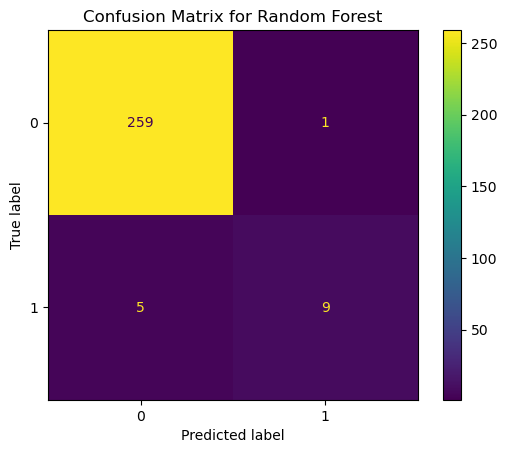

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title(f'Confusion Matrix for Random Forest')
plt.show()

In [58]:
joblib.dump(SVMC,"SVMC_large.joblib")

['SVMC_large.joblib']

#### GBC

In [29]:
# Creating a pipeline that includes preprocessing and the classifier
GBC = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 200))])

# Fitting the model
GBC.fit(X_train, y_train)

# Model evaluation
train_score = GBC.score(X_train, y_train)
test_score = GBC.score(X_test, y_test)

print(train_score, test_score)

y_pred = GBC.predict(X_test)
y_proba = GBC.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

probabilities = GBC.predict_proba(X_test)

# Extracting the probability of death, which is the second column of probabilities
death_probabilities = probabilities[:, 1]

# Showing the first few predictions for interpretation
death_probabilities[:10]

1.0 0.9744525547445255


array([0.08129365, 0.00361815, 0.00361815, 0.00361815, 0.07384307,
       0.00361815, 0.03264922, 0.00361815, 0.00361815, 0.03022866])

In [30]:
accuracy, precision, recall, f1, roc_auc

(0.9744525547445255,
 0.8888888888888888,
 0.5714285714285714,
 0.6956521739130435,
 0.9024725274725274)

In [31]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       260
           1       0.89      0.57      0.70        14

    accuracy                           0.97       274
   macro avg       0.93      0.78      0.84       274
weighted avg       0.97      0.97      0.97       274



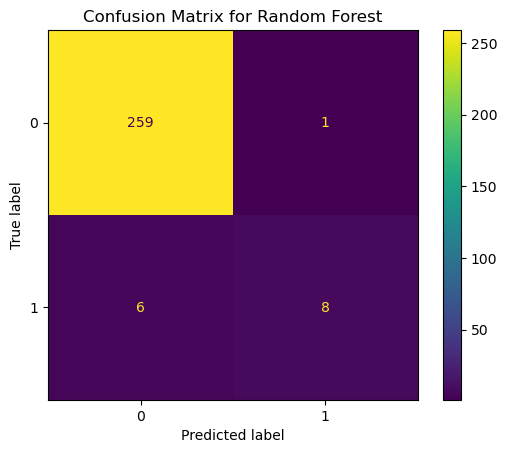

In [32]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title(f'Confusion Matrix for Random Forest')
plt.show()

In [19]:
probabilities = SVMC.predict_proba(X)

# Get the probabilities of death class (assuming it's the second column, index 1)
death_probabilities = probabilities[:, 1]

# Combine with the test set for a complete view
X_with_prob = pd.DataFrame(X.copy())
X_with_prob['Death_Probability'] = death_probabilities

# Sort the dataframe by 'Death_Probability' in descending order to get the highest probabilities at the top
X_with_prob_sorted = X_with_prob.sort_values(by = 'Death_Probability', ascending=False)

# Display the top 10 instances with the highest death probability
print(X_with_prob_sorted.iloc[0])

gender                                                                     M
race                                                                 UNKNOWN
lipase_level                                                          4860.0
age                                                                       63
length_of_stay                                                      1.294444
                                                                      ...   
Ventricular fibrillation                                               False
Ventricular tachycardia                                                False
Vitamin B12 deficiency anemia due to intrinsic factor deficiency       False
Acute pancreatitis                                                      True
Death_Probability                                                   0.999988
Name: 759, Length: 387, dtype: object


In [20]:
def deadly_disease(n):
    true_columns = []
    for i in range(n):
        row_data = X_with_prob_sorted.iloc[i]
        true_columns = true_columns + row_data[row_data == True].index.tolist()
    return true_columns

In [21]:
# finding top occuring disease for 50 patients diagnosed with AP and has high chance of death 
from collections import Counter
Counter(deadly_disease(50))

Counter({'Acute pancreatitis': 50,
         'Acidosis': 24,
         'Acute respiratory failure': 24,
         'Acute kidney failure with lesion of tubular necrosis': 18,
         'Severe sepsis': 18,
         'Encounter for palliative care': 18,
         'Acute kidney failure, unspecified': 17,
         'Unspecified septicemia': 15,
         'Atrial fibrillation': 14,
         'Septic shock': 12,
         'Other ascites': 11,
         'Acute respiratory failure with hypoxia': 10,
         'Do not resuscitate': 10,
         'Sepsis, unspecified organism': 10,
         'Congestive heart failure, unspecified': 10,
         'Do not resuscitate status': 10,
         'Thrombocytopenia, unspecified': 10,
         'Acute posthemorrhagic anemia': 9,
         'Severe sepsis with septic shock': 9,
         'Coronary atherosclerosis of native coronary artery': 9,
         'Acute kidney failure with tubular necrosis': 8,
         'Hyperosmolality and/or hypernatremia': 8,
         'Acute and subac